In [43]:
#Notebook to contain code for modelling a spiking neural network taking angular velocity as an input
import brian2 as b2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [84]:
#velocity data from simKex
velocity_df = pd.read_csv('velocity_data.csv')
velocity_df = velocity_df.drop('Unnamed: 0', axis='columns')
velocity = velocity_df.to_numpy()

timesteps = np.arange(0, len(velocity), 1)

In [85]:
velocity

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.43905112e-02,  0.00000000e+00,  0.00000000e+00],
       [ 8.54968265e-02, -3.33976703e-21,  3.49931225e-19],
       ...,
       [ 2.64296328e-01, -1.95258291e-21, -2.43889618e-18],
       [ 2.00352068e-01, -2.34529655e-20,  2.24710878e-18],
       [ 1.41138673e-01,  3.96643802e-21, -2.67198056e-18]])

Text(0, 0.5, 'v')

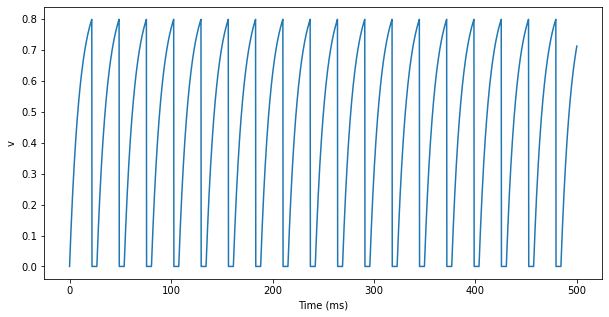

In [32]:
#LIF neuron
#Firing rate proportional to injected current I

#Needed before each sim to prevent error
b2.start_scope()

#constants/hyperparameters
tau = 10*b2.ms
threshold = 0.8
reset = 0
refractory = 5 * b2.ms
time = 500 * b2.ms
b2.defaultclock.dt = 0.1 * b2.ms


eqs = '''
dv/dt = (I-v)/tau : 1 (unless refractory)
I : 1
'''

G = b2.NeuronGroup(1, eqs, threshold='v>'+str(threshold), reset='v = '+str(reset), 
                    refractory=refractory, method='exact')

M = b2.StateMonitor(G, 'v', record=0)
S = b2.SpikeMonitor(G, variables='v')

G.I = 0.9

b2.run(time)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(M.t/b2.ms, M.v[0])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v')

In [34]:
S.v

<spikemonitor.v: array([0.80027716, 0.80027716, 0.80027716, 0.80027716, 0.80027716,
       0.80027716, 0.80027716, 0.80027716, 0.80027716, 0.80027716,
       0.80027716, 0.80027716, 0.80027716, 0.80027716, 0.80027716,
       0.80027716, 0.80027716, 0.80027716])>

Text(0, 0.5, 'Firing Rate')

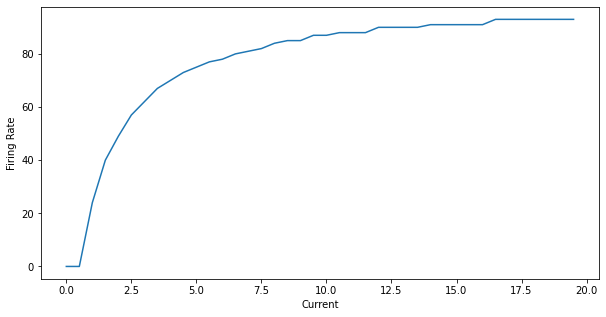

In [36]:
#LIF neuron FI curve

currents = np.arange(0,20,0.5)
fr = []
for i in currents:

    b2.start_scope()

    #constants/hyperparameters
    tau = 10*b2.ms
    threshold = 0.8
    reset = 0
    refractory = 5 * b2.ms
    time = 500 * b2.ms
    b2.defaultclock.dt = 0.1 * b2.ms


    eqs = '''
    dv/dt = (I-v)/tau : 1 (unless refractory)
    I : 1
    '''

    G = b2.NeuronGroup(1, eqs, threshold='v>'+str(threshold), reset='v = '+str(reset), 
                        refractory=refractory, method='exact')

    S = b2.SpikeMonitor(G, variables = 'v')

    G.I = i

    b2.run(time)

    fr.append(len(S.v))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(currents, fr)
ax.set_xlabel('Current')
ax.set_ylabel('Firing Rate')

Text(0, 0.5, 'v')

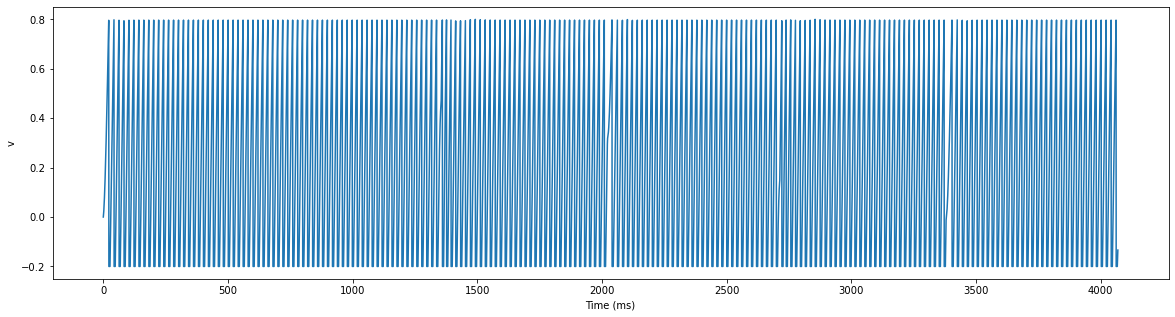

In [98]:
#Speed cell
#Firing rate proportional to speed
#Always firing, with higher speed = more firing, lower/0 speed = less firing (but still some)

#Needed before each sim to prevent error
b2.start_scope()

#constants/hyperparameters

#speed of voltage increase
tau = 100*b2.ms

#How much speed affects voltage
sW = 10

threshold = 0.8
reset = -0.2
refractory = 5 * b2.ms
time = len(timesteps) * b2.ms
b2.defaultclock.dt = 0.1 * b2.ms


eqs = '''
dv/dt = (1+I-v)/tau : 1 (unless refractory)
I : 1
step : 1
'''

G = b2.NeuronGroup(1, eqs, threshold='v>'+str(threshold), reset='v = '+str(reset), 
                    refractory=refractory, method='exact')

M = b2.StateMonitor(G, 'v', record=0)
G.I = 0
G.step = 0

@b2.network_operation(dt=1*b2.ms)
def getSpeed():
    G.I = sW * np.sum(np.abs(velocity[int(G.step[0])]))
    G.step += 1
b2.run(time)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(M.t/b2.ms, M.v[0])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v')

In [92]:
np.sum(np.abs(velocity[100]))

0.5997245824417345